# BERT semantic representation visualised through PCA embeddings

In [4]:
import time
from collections import namedtuple

import numpy as np
import pandas as pd
# from MulticoreTSNE import MulticoreTSNE as TSNE
from bert_serving.client import BertClient
from bert_serving.server import BertServer
from bert_serving.server.helper import get_args_parser
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

We take some sentences from wikipedia music article and wikipedia computer article and we visualise their semantic representation in BERT using PCA dimensionality reduction from 768 to 2.

In [62]:
wikipedia_music = """Music is an art form, and cultural activity, whose medium is sound. General definitions of music include common elements such as pitch (which governs melody and harmony), rhythm (and its associated concepts tempo, meter, and articulation), dynamics (loudness and softness), and the sonic qualities of timbre and texture (which are sometimes termed the "color" of a musical sound). Different styles or types of music may emphasize, de-emphasize or omit some of these elements. Music is performed with a vast range of instruments and vocal techniques ranging from singing to rapping; there are solely instrumental pieces, solely vocal pieces (such as songs without instrumental accompaniment) and pieces that combine singing and instruments. The word derives from Greek μουσική (mousike; "art of the Muses").[1] See glossary of musical terminology.
In its most general form, the activities describing music as an art form or cultural activity include the creation of works of music (songs, tunes, symphonies, and so on), the criticism of music, the study of the history of music, and the aesthetic examination of music. Ancient Greek and Indian philosophers defined music in two parts: melodies, as tones ordered horizontally, and harmonies as tones ordered vertically. Common sayings such as "the harmony of the spheres" and "it is music to my ears" point to the notion that music is often ordered and pleasant to listen to. However, 20th-century composer John Cage thought that any sound can be music, saying, for example, "There is no noise, only sound."[2]
The creation, performance, significance, and even the definition of music vary according to culture and social context. Indeed, throughout history, some new forms or styles of music have been criticized as "not being music", including Beethoven's Grosse Fuge string quartet in 1825,[3] early jazz in the beginning of the 1900s[4] and hardcore punk in the 1980s.[5] There are many types of music, including popular music, traditional music, art music, music written for religious ceremonies and work songs such as chanteys. Music ranges from strictly organized compositions—such as Classical music symphonies from the 1700s and 1800s—through to spontaneously played improvisational music such as jazz, and avant-garde styles of chance-based contemporary music from the 20th and 21st centuries.
Music can be divided into genres (e.g., country music) and genres can be further divided into subgenres (e.g., country blues and pop country are two of the many country subgenres), although the dividing lines and relationships between music genres are often subtle, sometimes open to personal interpretation, and occasionally controversial. For example, it can be hard to draw the line between some early 1980s hard rock and heavy metal. Within the arts, music may be classified as a performing art, a fine art or as an auditory art. Music may be played or sung and heard live at a rock concert or orchestra performance, heard live as part of a dramatic work (a music theater show or opera), or it may be recorded and listened to on a radio, MP3 player, CD player, smartphone or as film score or TV show.
In many cultures, music is an important part of people's way of life, as it plays a key role in religious rituals, rite of passage ceremonies (e.g., graduation and marriage), social activities (e.g., dancing) and cultural activities ranging from amateur karaoke singing to playing in an amateur funk band or singing in a community choir. People may make music as a hobby, like a teen playing cello in a youth orchestra, or work as a professional musician or singer. The music industry includes the individuals who create new songs and musical pieces (such as songwriters and composers), individuals who perform music (which include orchestra, jazz band and rock band musicians, singers and conductors), individuals who record music (music producers and sound engineers), individuals who organize concert tours, and individuals who sell recordings, sheet music, and scores to customers. Even once a song or piece has been performed, music critics, music journalists, and music scholars may assess and evaluate the piece and its performance."""
wikipedia_computer = """A computer is a machine that can be instructed to carry out sequences of arithmetic or logical operations automatically via computer programming. Modern computers have the ability to follow generalized sets of operations, called programs. These programs enable computers to perform an extremely wide range of tasks. A "complete" computer including the hardware, the operating system (main software), and peripheral equipment required and used for "full" operation can be referred to as a computer system. This term may as well be used for a group of computers that are connected and work together, in particular a computer network or computer cluster.
Computers are used as control systems for a wide variety of industrial and consumer devices. This includes simple special purpose devices like microwave ovens and remote controls, factory devices such as industrial robots and computer-aided design, and also general purpose devices like personal computers and mobile devices such as smartphones. The Internet is run on computers and it connects hundreds of millions of other computers and their users.
Early computers were only conceived as calculating devices. Since ancient times, simple manual devices like the abacus aided people in doing calculations. Early in the Industrial Revolution, some mechanical devices were built to automate long tedious tasks, such as guiding patterns for looms. More sophisticated electrical machines did specialized analog calculations in the early 20th century. The first digital electronic calculating machines were developed during World War II. The first semiconductor transistors in the late 1940s were followed by the silicon-based MOSFET (MOS transistor) and monolithic integrated circuit (IC) chip technologies in the late 1950s, leading to the microprocessor and the microcomputer revolution in the 1970s. The speed, power and versatility of computers have been increasing dramatically ever since then, with MOS transistor counts increasing at a rapid pace (as predicted by Moore's law), leading to the Digital Revolution during the late 20th to early 21st centuries.
Conventionally, a modern computer consists of at least one processing element, typically a central processing unit (CPU) in the form of a metal-oxide-semiconductor (MOS) microprocessor, along with some type of computer memory, typically MOS semiconductor memory chips. The processing element carries out arithmetic and logical operations, and a sequencing and control unit can change the order of operations in response to stored information. Peripheral devices include input devices (keyboards, mice, joystick, etc.), output devices (monitor screens, printers, etc.), and input/output devices that perform both functions (e.g., the 2000s-era touchscreen). Peripheral devices allow information to be retrieved from an external source and they enable the result of operations to be saved and retrieved.
"""

In [80]:
music_sentences = wikipedia_music.split('.') 
music_sentences = [*filter(lambda x: len(x) > 5, music_sentences)]
computer_sentences = wikipedia_computer.split('.') 
computer_sentences = [*filter(lambda x: len(x) > 5, computer_sentences)]
sentences = music_sentences + computer_sentences
labels = [0 for _ in music_sentences] + [1 for _ in computer_sentences]

In [81]:
print(sentences[20], labels[20])
print(sentences[40], labels[40])


In many cultures, music is an important part of people's way of life, as it plays a key role in religious rituals, rite of passage ceremonies (e 0
 The speed, power and versatility of computers have been increasing dramatically ever since then, with MOS transistor counts increasing at a rapid pace (as predicted by Moore's law), leading to the Digital Revolution during the late 20th to early 21st centuries 1


In [13]:
pool_layer = 1
subset_vec_all_layers = []
port = 6006
port_out = 6007

In [16]:
common = [
    '-model_dir', '../uncased_L-12_H-768_A-12/',
    '-num_worker', '2',
    '-port', str(port),
    '-port_out', str(port_out),
    '-max_seq_len', '20',
    # '-client_batch_size', '2048',
    '-max_batch_size', '256',
    # '-num_client', '1',
    '-pooling_strategy', 'REDUCE_MEAN',
    '-pooling_layer', '-2',
    '-gpu_memory_fraction', '0.2',
    '-device','3',
]
args = get_args_parser().parse_args(common)

## 1 LAYER ENCODING

In [49]:
len(sentences)

6

In [46]:
setattr(args, 'pooling_layer', [-1])
server = BertServer(args)
server.start()
print('wait until server is ready...')
time.sleep(20)
print('encoding...')
bc = BertClient(port=port, port_out=port_out, show_server_config=True)
layer = bc.encode(sentences)


I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...
I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp58h9qmtm
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp58h9qmtm
I:VENTILATOR:[__i:_ru:129]:bind all sockets
I:VENTILATOR:[__i:_ru:133]:open 8 ventilator-worker sockets
I:VENTILATOR:[__i:_ru:136]:start the sink


wait until server is ready...


I:VENTILATOR:[__i:_ge:222]:get devices
I:SINK:[__i:_ru:306]:ready
W:VENTILATOR:[__i:_ge:246]:no GPU available, fall back to CPU
I:VENTILATOR:[__i:_ge:255]:device map: 
		worker  0 -> cpu
		worker  1 -> cpu
I:WORKER-0:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp58h9qmtm
I:WORKER-1:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp58h9qmtm


encoding...


I:WORKER-0:[__i:gen:559]:ready and listening!
I:WORKER-1:[__i:gen:559]:ready and listening!
I:VENTILATOR:[__i:_ru:164]:all set, ready to serve request!
I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'3af4c877-cdd1-4678-98ed-2d8545a12b4e'
I:SINK:[__i:_ru:348]:send config	client b'3af4c877-cdd1-4678-98ed-2d8545a12b4e'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)
I:VENTILATOR:[__i:_ru:196]:new encode request	req id: 2	size: 6	client: b'3af4c877-cdd1-4678-98ed-2d8545a12b4e'
I:

server config:
                        client	=	3af4c877-cdd1-4678-98ed-2d8545a12b4e
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpOkN4bU/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpaBTF5H/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmplfj0DR/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpaB32n9/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpFO9a3L/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpGoqElQ/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpgD6vKt/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpfdodZD/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp6v249I/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpKfmLrT/socket
       

I:WORKER-0:[__i:_ru:543]:job done	size: (6, 768)	client: b'3af4c877-cdd1-4678-98ed-2d8545a12b4e#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'3af4c877-cdd1-4678-98ed-2d8545a12b4e#2' (E:6/T:0/A:6)
I:SINK:[__i:_ru:357]:send back	size: 6	job id: b'3af4c877-cdd1-4678-98ed-2d8545a12b4e#2'
I:SINK:[__i:_ru:348]:send config	client b'6693eb83-c1c9-4d9d-8ffa-c4cb09b23f71'
I:SINK:[__i:_ru:348]:send config	client b'0444f554-ef32-4b9d-841a-9517ab3d37de'
I:SINK:[__i:_ru:348]:send config	client b'885c3e27-e823-4613-9933-076de73d2ed9'
I:SINK:[__i:_ru:342]:job register	size: 48	job id: b'885c3e27-e823-4613-9933-076de73d2ed9#2'
I:WORKER-0:[__i:gen:568]:new job	socket: 4	size: 48	client: b'885c3e27-e823-4613-9933-076de73d2ed9#2'
I:WORKER-0:[__i:_ru:543]:job done	size: (48, 768)	client: b'885c3e27-e823-4613-9933-076de73d2ed9#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'885c3e27-e823-4613-9933-076de73d2ed9#2' (E:48/T:0/A:48)
I:SINK:[__i:_ru:357]:send back	size: 48	job id: b'885c3e27-e823-4613-9933-076

In [55]:
layer # this is the representation of the sentences according to the last layer

array([[ 0.20987064,  0.31956345,  0.25079218, ..., -0.15221317,
         0.15055206,  0.29068577],
       [-0.02111052,  0.4687631 ,  0.03027946, ..., -0.25198817,
        -0.09379932,  0.56720257],
       [ 0.27522296,  0.5435899 ,  0.20149453, ...,  0.08233873,
         0.13124003,  0.2907262 ],
       [ 0.01224182, -0.03252828,  0.0662064 , ..., -0.13583335,
         0.2631879 ,  0.32271793],
       [-0.16499576,  0.08829265, -0.12111602, ..., -0.26839983,
        -0.3567505 ,  0.66461146],
       [-0.17282781, -0.03886478, -0.11333249, ..., -0.17703345,
        -0.20369813,  0.11287816]], dtype=float32)

## FULL 12 LAYERS ENCODING

In [82]:
subset_vec_all_layers = []
for pool_layer in range(1, 13):
    setattr(args, 'pooling_layer', [-pool_layer])
    server = BertServer(args)
    server.start()
    print('wait until server is ready...')
    time.sleep(20)
    print('encoding...')
    bc = BertClient(port=port, port_out=port_out, show_server_config=True)
    subset_vec_all_layers.append(bc.encode(sentences))
    bc.close()
    server.close()
    print('done at layer -%d' % pool_layer)

I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...
I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmphiwgjj2g
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmphiwgjj2g
I:VENTILATOR:[__i:_ru:129]:bind all sockets
Exception in thread Thread-73:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python37/3.7.5_3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/server/__init__.py", line 115, in run
    self._run()
  File "/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/zmq/decorators.py", line 75, in wrapper
    return func(*args, **kwargs)
  File "/Users/lessandro/Coding/AI/BERT/embeddings/venv/li

wait until server is ready...


I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'885c3e27-e823-4613-9933-076de73d2ed9'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)
I:VENTILATOR:[__i:_ru:196]:new encode request	req id: 2	size: 48	client: b'885c3e27-e823-4613-9933-076de73d2ed9'


encoding...
server config:
                        client	=	885c3e27-e823-4613-9933-076de73d2ed9
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpOkN4bU/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpaBTF5H/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmplfj0DR/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpaB32n9/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpFO9a3L/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpGoqElQ/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpgD6vKt/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpfdodZD/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp6v249I/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpKfmLrT/so

I:VENTILATOR:[__i:clo: 89]:shutting down...
I:SINK:[__i:clo:274]:shutting down...
I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...


done at layer -1


I:SINK:[__i:clo:279]:terminated!
I:WORKER-0:[__i:clo:481]:shutting down...
I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...
I:WORKER-0:[__i:clo:486]:terminated!
I:WORKER-1:[__i:clo:481]:shutting down...
I:WORKER-1:[__i:clo:486]:terminated!
I:VENTILATOR:[__i:_ru:219]:terminated!



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpf_pxbz82
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpf_pxbz82
I:VENTILATOR:[__i:_ru:129]:bind all sockets
I:VENTILATOR:[__i:_ru:133]:open 8 ventilator-worker sockets
I:VENTILATOR:[__i:_ru:136]:start the sink


wait until server is ready...


I:VENTILATOR:[__i:_ge:222]:get devices
I:SINK:[__i:_ru:306]:ready
W:VENTILATOR:[__i:_ge:246]:no GPU available, fall back to CPU
I:VENTILATOR:[__i:_ge:255]:device map: 
		worker  0 -> cpu
		worker  1 -> cpu
I:WORKER-0:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpf_pxbz82
I:WORKER-1:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpf_pxbz82


encoding...


I:WORKER-0:[__i:gen:559]:ready and listening!
I:WORKER-1:[__i:gen:559]:ready and listening!
I:VENTILATOR:[__i:_ru:164]:all set, ready to serve request!
I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'6c8c9d46-3c5b-4155-9230-4b14278bcffa'
I:SINK:[__i:_ru:348]:send config	client b'6c8c9d46-3c5b-4155-9230-4b14278bcffa'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)
I:VENTILATOR:[__i:_ru:196]:new encode request	req id: 2	size: 48	client: b'6c8c9d46-3c5b-4155-9230-4b14278bcffa'
I

server config:
                        client	=	6c8c9d46-3c5b-4155-9230-4b14278bcffa
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpVjQ1cW/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp9fyreV/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpLgjH1L/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpTVz72h/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpsWEeoB/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp5tAOKY/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpc8yoCa/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp30yS8s/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpGSEtqk/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpmrqe6Y/socket
       

I:WORKER-0:[__i:_ru:543]:job done	size: (48, 768)	client: b'6c8c9d46-3c5b-4155-9230-4b14278bcffa#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'6c8c9d46-3c5b-4155-9230-4b14278bcffa#2' (E:48/T:0/A:48)
I:SINK:[__i:_ru:357]:send back	size: 48	job id: b'6c8c9d46-3c5b-4155-9230-4b14278bcffa#2'
I:VENTILATOR:[__i:clo: 89]:shutting down...
I:SINK:[__i:clo:274]:shutting down...
I:SINK:[__i:clo:279]:terminated!
I:WORKER-0:[__i:clo:481]:shutting down...
I:WORKER-0:[__i:clo:486]:terminated!
I:WORKER-1:[__i:clo:481]:shutting down...
I:WORKER-1:[__i:clo:486]:terminated!
I:VENTILATOR:[__i:_ru:219]:terminated!
I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...


done at layer -2


I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpawf9ms6v
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpawf9ms6v
I:VENTILATOR:[__i:_ru:129]:bind all sockets
I:VENTILATOR:[__i:_ru:133]:open 8 ventilator-worker sockets
I:VENTILATOR:[__i:_ru:136]:start the sink


wait until server is ready...


I:VENTILATOR:[__i:_ge:222]:get devices
I:SINK:[__i:_ru:306]:ready
W:VENTILATOR:[__i:_ge:246]:no GPU available, fall back to CPU
I:VENTILATOR:[__i:_ge:255]:device map: 
		worker  0 -> cpu
		worker  1 -> cpu
I:WORKER-0:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpawf9ms6v
I:WORKER-1:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpawf9ms6v
I:WORKER-0:[__i:gen:559]:ready and listening!
I:WORKER-1:[__i:gen:559]:ready and listening!
I:VENTILATOR:[__i:_ru:164]:all set, ready to serve request!
I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'76b8c12d-b513-4466-9ad3-7a50b5b70420'
I:SINK:[__i:_ru:348]:send config	client b'76b8c12d-b513-4466-9ad3-7a50b5b70420'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence 

encoding...
server config:
                        client	=	76b8c12d-b513-4466-9ad3-7a50b5b70420
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpz2iBsk/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpCRruiB/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpcbvVnT/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpyzlhmP/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpzrB2Xg/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpLRbo6w/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpKGAQnV/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpR7OOqO/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpYhOqaK/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpeG4Lvt/so

I:WORKER-0:[__i:_ru:543]:job done	size: (48, 768)	client: b'76b8c12d-b513-4466-9ad3-7a50b5b70420#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'76b8c12d-b513-4466-9ad3-7a50b5b70420#2' (E:48/T:0/A:48)
I:SINK:[__i:_ru:357]:send back	size: 48	job id: b'76b8c12d-b513-4466-9ad3-7a50b5b70420#2'
I:VENTILATOR:[__i:clo: 89]:shutting down...
I:SINK:[__i:clo:274]:shutting down...
I:SINK:[__i:clo:279]:terminated!
I:WORKER-0:[__i:clo:481]:shutting down...
I:WORKER-0:[__i:clo:486]:terminated!
I:WORKER-1:[__i:clo:481]:shutting down...
I:WORKER-1:[__i:clo:486]:terminated!
I:VENTILATOR:[__i:_ru:219]:terminated!
I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...


done at layer -3


I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpp9zqq0t_
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpp9zqq0t_
I:VENTILATOR:[__i:_ru:129]:bind all sockets
I:VENTILATOR:[__i:_ru:133]:open 8 ventilator-worker sockets
I:VENTILATOR:[__i:_ru:136]:start the sink


wait until server is ready...


I:VENTILATOR:[__i:_ge:222]:get devices
I:SINK:[__i:_ru:306]:ready
W:VENTILATOR:[__i:_ge:246]:no GPU available, fall back to CPU
I:VENTILATOR:[__i:_ge:255]:device map: 
		worker  0 -> cpu
		worker  1 -> cpu
I:WORKER-0:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpp9zqq0t_
I:WORKER-1:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpp9zqq0t_
I:WORKER-1:[__i:gen:559]:ready and listening!
I:WORKER-0:[__i:gen:559]:ready and listening!
I:VENTILATOR:[__i:_ru:164]:all set, ready to serve request!
I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'10fe0188-1070-4b5d-98a7-1b704754b179'
I:SINK:[__i:_ru:348]:send config	client b'10fe0188-1070-4b5d-98a7-1b704754b179'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence 

encoding...
server config:
                        client	=	10fe0188-1070-4b5d-98a7-1b704754b179
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpQ9XJYx/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp5COnkZ/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpzO2mj9/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp88QwvK/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpyQNq3G/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpbs1YrJ/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpsIGUaZ/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpl2TKzd/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp4zdQFT/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpX413XO/so

I:WORKER-0:[__i:_ru:543]:job done	size: (48, 768)	client: b'10fe0188-1070-4b5d-98a7-1b704754b179#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'10fe0188-1070-4b5d-98a7-1b704754b179#2' (E:48/T:0/A:48)
I:SINK:[__i:_ru:357]:send back	size: 48	job id: b'10fe0188-1070-4b5d-98a7-1b704754b179#2'
I:VENTILATOR:[__i:clo: 89]:shutting down...
I:SINK:[__i:clo:274]:shutting down...
I:SINK:[__i:clo:279]:terminated!
I:WORKER-0:[__i:clo:481]:shutting down...
I:WORKER-0:[__i:clo:486]:terminated!
I:WORKER-1:[__i:clo:481]:shutting down...
I:WORKER-1:[__i:clo:486]:terminated!
I:VENTILATOR:[__i:_ru:219]:terminated!
I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...


done at layer -4


I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp34hu9zal
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp34hu9zal
I:VENTILATOR:[__i:_ru:129]:bind all sockets
I:VENTILATOR:[__i:_ru:133]:open 8 ventilator-worker sockets
I:VENTILATOR:[__i:_ru:136]:start the sink


wait until server is ready...


I:VENTILATOR:[__i:_ge:222]:get devices
I:SINK:[__i:_ru:306]:ready
W:VENTILATOR:[__i:_ge:246]:no GPU available, fall back to CPU
I:VENTILATOR:[__i:_ge:255]:device map: 
		worker  0 -> cpu
		worker  1 -> cpu
I:WORKER-0:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp34hu9zal
I:WORKER-1:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp34hu9zal
I:WORKER-1:[__i:gen:559]:ready and listening!
I:WORKER-0:[__i:gen:559]:ready and listening!
I:VENTILATOR:[__i:_ru:164]:all set, ready to serve request!
I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'9ea6abfd-af41-47c9-9c27-b0df6f81f700'
I:SINK:[__i:_ru:348]:send config	client b'9ea6abfd-af41-47c9-9c27-b0df6f81f700'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence 

encoding...
server config:
                        client	=	9ea6abfd-af41-47c9-9c27-b0df6f81f700
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpig1bk1/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpy971kh/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpTFYM8R/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpTSeM9D/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpyE5FqY/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpp3RPSj/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpjoSvE7/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpd3v1ED/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmplDTVuv/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpm8qnuO/so

I:WORKER-0:[__i:_ru:543]:job done	size: (48, 768)	client: b'9ea6abfd-af41-47c9-9c27-b0df6f81f700#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'9ea6abfd-af41-47c9-9c27-b0df6f81f700#2' (E:48/T:0/A:48)
I:SINK:[__i:_ru:357]:send back	size: 48	job id: b'9ea6abfd-af41-47c9-9c27-b0df6f81f700#2'
I:VENTILATOR:[__i:clo: 89]:shutting down...
I:SINK:[__i:clo:274]:shutting down...
I:SINK:[__i:clo:279]:terminated!
I:WORKER-0:[__i:clo:481]:shutting down...
I:WORKER-0:[__i:clo:486]:terminated!
I:WORKER-1:[__i:clo:481]:shutting down...
I:WORKER-1:[__i:clo:486]:terminated!
I:VENTILATOR:[__i:_ru:219]:terminated!
I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...


done at layer -5


I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpkgr_4_60
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpkgr_4_60
I:VENTILATOR:[__i:_ru:129]:bind all sockets
I:VENTILATOR:[__i:_ru:133]:open 8 ventilator-worker sockets
I:VENTILATOR:[__i:_ru:136]:start the sink


wait until server is ready...


I:VENTILATOR:[__i:_ge:222]:get devices
I:SINK:[__i:_ru:306]:ready
W:VENTILATOR:[__i:_ge:246]:no GPU available, fall back to CPU
I:VENTILATOR:[__i:_ge:255]:device map: 
		worker  0 -> cpu
		worker  1 -> cpu
I:WORKER-0:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpkgr_4_60
I:WORKER-1:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpkgr_4_60
I:WORKER-1:[__i:gen:559]:ready and listening!
I:WORKER-0:[__i:gen:559]:ready and listening!
I:VENTILATOR:[__i:_ru:164]:all set, ready to serve request!
I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'1b4ae844-ac76-40a2-9637-11319703e6ff'
I:SINK:[__i:_ru:348]:send config	client b'1b4ae844-ac76-40a2-9637-11319703e6ff'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence 

encoding...
server config:
                        client	=	1b4ae844-ac76-40a2-9637-11319703e6ff
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpZdO3F2/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp8saB4t/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpwLmIhM/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpIYExqQ/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpMQv6gt/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpc6RTio/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpJrfRcZ/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmppypfYz/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpFw97uR/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpqYPLJr/so

I:WORKER-0:[__i:_ru:543]:job done	size: (48, 768)	client: b'1b4ae844-ac76-40a2-9637-11319703e6ff#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'1b4ae844-ac76-40a2-9637-11319703e6ff#2' (E:48/T:0/A:48)
I:SINK:[__i:_ru:357]:send back	size: 48	job id: b'1b4ae844-ac76-40a2-9637-11319703e6ff#2'
I:VENTILATOR:[__i:clo: 89]:shutting down...
I:SINK:[__i:clo:274]:shutting down...
I:SINK:[__i:clo:279]:terminated!
I:WORKER-0:[__i:clo:481]:shutting down...
I:WORKER-0:[__i:clo:486]:terminated!
I:WORKER-1:[__i:clo:481]:shutting down...
I:WORKER-1:[__i:clo:486]:terminated!
I:VENTILATOR:[__i:_ru:219]:terminated!
I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...


done at layer -6


I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp05fgzc_e
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp05fgzc_e
I:VENTILATOR:[__i:_ru:129]:bind all sockets
I:VENTILATOR:[__i:_ru:133]:open 8 ventilator-worker sockets
I:VENTILATOR:[__i:_ru:136]:start the sink


wait until server is ready...


I:VENTILATOR:[__i:_ge:222]:get devices
I:SINK:[__i:_ru:306]:ready
W:VENTILATOR:[__i:_ge:246]:no GPU available, fall back to CPU
I:VENTILATOR:[__i:_ge:255]:device map: 
		worker  0 -> cpu
		worker  1 -> cpu
I:WORKER-0:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp05fgzc_e
I:WORKER-1:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp05fgzc_e
I:WORKER-0:[__i:gen:559]:ready and listening!
I:WORKER-1:[__i:gen:559]:ready and listening!
I:VENTILATOR:[__i:_ru:164]:all set, ready to serve request!
I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'be6d10db-c74c-4914-a8ea-c2ea0c2809be'
I:SINK:[__i:_ru:348]:send config	client b'be6d10db-c74c-4914-a8ea-c2ea0c2809be'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence 

encoding...
server config:
                        client	=	be6d10db-c74c-4914-a8ea-c2ea0c2809be
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp0vb9hY/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp7ymkWx/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpycJlyw/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpjoDsyr/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpHpxbfK/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmptpysTn/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp3evqXd/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpdgBXWw/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp2TtArG/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpJap1Oz/so

I:WORKER-0:[__i:_ru:543]:job done	size: (48, 768)	client: b'be6d10db-c74c-4914-a8ea-c2ea0c2809be#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'be6d10db-c74c-4914-a8ea-c2ea0c2809be#2' (E:48/T:0/A:48)
I:SINK:[__i:_ru:357]:send back	size: 48	job id: b'be6d10db-c74c-4914-a8ea-c2ea0c2809be#2'
I:VENTILATOR:[__i:clo: 89]:shutting down...
I:SINK:[__i:clo:274]:shutting down...
I:SINK:[__i:clo:279]:terminated!
I:WORKER-0:[__i:clo:481]:shutting down...
I:WORKER-0:[__i:clo:486]:terminated!
I:WORKER-1:[__i:clo:481]:shutting down...
I:WORKER-1:[__i:clo:486]:terminated!
I:VENTILATOR:[__i:_ru:219]:terminated!
I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...


done at layer -7


I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpcuscghfh
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpcuscghfh
I:VENTILATOR:[__i:_ru:129]:bind all sockets
I:VENTILATOR:[__i:_ru:133]:open 8 ventilator-worker sockets
I:VENTILATOR:[__i:_ru:136]:start the sink


wait until server is ready...


I:VENTILATOR:[__i:_ge:222]:get devices
I:SINK:[__i:_ru:306]:ready
W:VENTILATOR:[__i:_ge:246]:no GPU available, fall back to CPU
I:VENTILATOR:[__i:_ge:255]:device map: 
		worker  0 -> cpu
		worker  1 -> cpu
I:WORKER-0:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpcuscghfh
I:WORKER-1:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpcuscghfh
I:WORKER-1:[__i:gen:559]:ready and listening!
I:WORKER-0:[__i:gen:559]:ready and listening!
I:VENTILATOR:[__i:_ru:164]:all set, ready to serve request!
I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'dd4a02a5-a01d-4e17-a775-af4ba5a9d6a4'
I:SINK:[__i:_ru:348]:send config	client b'dd4a02a5-a01d-4e17-a775-af4ba5a9d6a4'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence 

encoding...
server config:
                        client	=	dd4a02a5-a01d-4e17-a775-af4ba5a9d6a4
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmptYQqYZ/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpQjFtSQ/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpNMrM9Y/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpDdFT3h/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpWkD98w/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpxjeG91/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpB52Xbh/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpxFKX00/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpqIly5Y/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpKvwMmz/so

I:WORKER-0:[__i:_ru:543]:job done	size: (48, 768)	client: b'dd4a02a5-a01d-4e17-a775-af4ba5a9d6a4#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'dd4a02a5-a01d-4e17-a775-af4ba5a9d6a4#2' (E:48/T:0/A:48)
I:SINK:[__i:_ru:357]:send back	size: 48	job id: b'dd4a02a5-a01d-4e17-a775-af4ba5a9d6a4#2'
I:VENTILATOR:[__i:clo: 89]:shutting down...
I:SINK:[__i:clo:274]:shutting down...
I:SINK:[__i:clo:279]:terminated!
I:WORKER-0:[__i:clo:481]:shutting down...
I:WORKER-0:[__i:clo:486]:terminated!
I:WORKER-1:[__i:clo:481]:shutting down...
I:WORKER-1:[__i:clo:486]:terminated!
I:VENTILATOR:[__i:_ru:219]:terminated!
I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...


done at layer -8


I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmps5d6l8bq
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmps5d6l8bq
I:VENTILATOR:[__i:_ru:129]:bind all sockets
I:VENTILATOR:[__i:_ru:133]:open 8 ventilator-worker sockets
I:VENTILATOR:[__i:_ru:136]:start the sink


wait until server is ready...


I:VENTILATOR:[__i:_ge:222]:get devices
I:SINK:[__i:_ru:306]:ready
W:VENTILATOR:[__i:_ge:246]:no GPU available, fall back to CPU
I:VENTILATOR:[__i:_ge:255]:device map: 
		worker  0 -> cpu
		worker  1 -> cpu
I:WORKER-0:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmps5d6l8bq
I:WORKER-1:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmps5d6l8bq
I:WORKER-1:[__i:gen:559]:ready and listening!
I:WORKER-0:[__i:gen:559]:ready and listening!
I:VENTILATOR:[__i:_ru:164]:all set, ready to serve request!
I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'9e4c863b-7cc9-44cc-b13b-b003dcc54411'
I:SINK:[__i:_ru:348]:send config	client b'9e4c863b-7cc9-44cc-b13b-b003dcc54411'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence 

encoding...
server config:
                        client	=	9e4c863b-7cc9-44cc-b13b-b003dcc54411
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpzrMWKn/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp22zXNk/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpRrjwfw/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp6Go8Os/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpifhmuD/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpNBbED1/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpMrXUCs/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpxcaCCG/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpTZFd11/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp6ZuT20/so

I:WORKER-0:[__i:_ru:543]:job done	size: (48, 768)	client: b'9e4c863b-7cc9-44cc-b13b-b003dcc54411#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'9e4c863b-7cc9-44cc-b13b-b003dcc54411#2' (E:48/T:0/A:48)
I:SINK:[__i:_ru:357]:send back	size: 48	job id: b'9e4c863b-7cc9-44cc-b13b-b003dcc54411#2'
I:VENTILATOR:[__i:clo: 89]:shutting down...
I:SINK:[__i:clo:274]:shutting down...
I:SINK:[__i:clo:279]:terminated!
I:WORKER-0:[__i:clo:481]:shutting down...
I:WORKER-0:[__i:clo:486]:terminated!
I:WORKER-1:[__i:clo:481]:shutting down...
I:WORKER-1:[__i:clo:486]:terminated!
I:VENTILATOR:[__i:_ru:219]:terminated!
I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...


done at layer -9


I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpvb0o_4f2
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpvb0o_4f2
I:VENTILATOR:[__i:_ru:129]:bind all sockets
I:VENTILATOR:[__i:_ru:133]:open 8 ventilator-worker sockets
I:VENTILATOR:[__i:_ru:136]:start the sink


wait until server is ready...


I:VENTILATOR:[__i:_ge:222]:get devices
I:SINK:[__i:_ru:306]:ready
W:VENTILATOR:[__i:_ge:246]:no GPU available, fall back to CPU
I:VENTILATOR:[__i:_ge:255]:device map: 
		worker  0 -> cpu
		worker  1 -> cpu
I:WORKER-0:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpvb0o_4f2
I:WORKER-1:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpvb0o_4f2
I:WORKER-0:[__i:gen:559]:ready and listening!
I:WORKER-1:[__i:gen:559]:ready and listening!
I:VENTILATOR:[__i:_ru:164]:all set, ready to serve request!
I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'06603fcc-9285-4a07-a379-1c91ab08ea87'
I:SINK:[__i:_ru:348]:send config	client b'06603fcc-9285-4a07-a379-1c91ab08ea87'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence 

encoding...
server config:
                        client	=	06603fcc-9285-4a07-a379-1c91ab08ea87
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpdxJoI2/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp6AnTLP/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpgZKmRX/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpGQkuwY/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpqhAppF/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp0zShDO/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpijxomh/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpOSJmn2/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpiEeIpt/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp2pPa6l/so

I:WORKER-0:[__i:_ru:543]:job done	size: (48, 768)	client: b'06603fcc-9285-4a07-a379-1c91ab08ea87#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'06603fcc-9285-4a07-a379-1c91ab08ea87#2' (E:48/T:0/A:48)
I:SINK:[__i:_ru:357]:send back	size: 48	job id: b'06603fcc-9285-4a07-a379-1c91ab08ea87#2'
I:VENTILATOR:[__i:clo: 89]:shutting down...
I:SINK:[__i:clo:274]:shutting down...
I:SINK:[__i:clo:279]:terminated!
I:WORKER-0:[__i:clo:481]:shutting down...
I:WORKER-0:[__i:clo:486]:terminated!
I:WORKER-1:[__i:clo:481]:shutting down...
I:WORKER-1:[__i:clo:486]:terminated!
I:VENTILATOR:[__i:_ru:219]:terminated!
I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...


done at layer -10


I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpwvldjun3
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpwvldjun3
I:VENTILATOR:[__i:_ru:129]:bind all sockets
I:VENTILATOR:[__i:_ru:133]:open 8 ventilator-worker sockets
I:VENTILATOR:[__i:_ru:136]:start the sink


wait until server is ready...


I:VENTILATOR:[__i:_ge:222]:get devices
I:SINK:[__i:_ru:306]:ready
W:VENTILATOR:[__i:_ge:246]:no GPU available, fall back to CPU
I:VENTILATOR:[__i:_ge:255]:device map: 
		worker  0 -> cpu
		worker  1 -> cpu
I:WORKER-0:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpwvldjun3
I:WORKER-1:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpwvldjun3
I:WORKER-0:[__i:gen:559]:ready and listening!
I:WORKER-1:[__i:gen:559]:ready and listening!
I:VENTILATOR:[__i:_ru:164]:all set, ready to serve request!
I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'916f60e5-8293-426c-9c21-4044c1bf5fc5'
I:SINK:[__i:_ru:348]:send config	client b'916f60e5-8293-426c-9c21-4044c1bf5fc5'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence 

encoding...
server config:
                        client	=	916f60e5-8293-426c-9c21-4044c1bf5fc5
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpcM4qUp/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpup377x/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpHTObW0/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpMHX5Rq/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpjgMbcI/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpgN1XgB/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpNv6tjc/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpXakyAT/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpRDuoFU/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpi9QcIv/so

I:WORKER-0:[__i:_ru:543]:job done	size: (48, 768)	client: b'916f60e5-8293-426c-9c21-4044c1bf5fc5#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'916f60e5-8293-426c-9c21-4044c1bf5fc5#2' (E:48/T:0/A:48)
I:SINK:[__i:_ru:357]:send back	size: 48	job id: b'916f60e5-8293-426c-9c21-4044c1bf5fc5#2'
I:VENTILATOR:[__i:clo: 89]:shutting down...
I:SINK:[__i:clo:274]:shutting down...
I:SINK:[__i:clo:279]:terminated!
I:WORKER-0:[__i:clo:481]:shutting down...
I:WORKER-0:[__i:clo:486]:terminated!
I:WORKER-1:[__i:clo:481]:shutting down...
I:WORKER-1:[__i:clo:486]:terminated!
I:VENTILATOR:[__i:_ru:219]:terminated!
I:VENTILATOR:[__i:__i: 67]:freeze, optimize and export graph, could take a while...


done at layer -11


I:GRAPHOPT:[gra:opt: 53]:model config: ../uncased_L-12_H-768_A-12/bert_config.json
I:GRAPHOPT:[gra:opt: 56]:checkpoint: ../uncased_L-12_H-768_A-12/bert_model.ckpt
I:GRAPHOPT:[gra:opt: 60]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:GRAPHOPT:[gra:opt:132]:load parameters from checkpoint...
I:GRAPHOPT:[gra:opt:136]:optimize...
I:GRAPHOPT:[gra:opt:144]:freeze...
I:GRAPHOPT:[gra:opt:149]:write graph to a tmp file: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpma7aox6_
I:VENTILATOR:[__i:__i: 75]:optimized graph is stored at: /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpma7aox6_
I:VENTILATOR:[__i:_ru:129]:bind all sockets
I:VENTILATOR:[__i:_ru:133]:open 8 ventilator-worker sockets
I:VENTILATOR:[__i:_ru:136]:start the sink


wait until server is ready...


I:VENTILATOR:[__i:_ge:222]:get devices
I:SINK:[__i:_ru:306]:ready
W:VENTILATOR:[__i:_ge:246]:no GPU available, fall back to CPU
I:VENTILATOR:[__i:_ge:255]:device map: 
		worker  0 -> cpu
		worker  1 -> cpu
I:WORKER-0:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpma7aox6_
I:WORKER-1:[__i:_ru:531]:use device cpu, load graph from /var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpma7aox6_
I:WORKER-1:[__i:gen:559]:ready and listening!
I:WORKER-0:[__i:gen:559]:ready and listening!
I:VENTILATOR:[__i:_ru:164]:all set, ready to serve request!
I:VENTILATOR:[__i:_ru:180]:new config request	req id: 1	client: b'58c5bcc7-46bc-4fb5-a29f-fac59f6c490d'
I:SINK:[__i:_ru:348]:send config	client b'58c5bcc7-46bc-4fb5-a29f-fac59f6c490d'
/Users/lessandro/Coding/AI/BERT/embeddings/venv/lib/python3.7/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=20" set on the server, as consequence 

encoding...
server config:
                        client	=	58c5bcc7-46bc-4fb5-a29f-fac59f6c490d
                   num_process	=	3                             
          ventilator -> worker	=	['ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpFgq180/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpUNfoO8/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmppQNqJx/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpMS2nN5/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpuxZcki/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpjEefSw/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmp2NVG8R/socket', 'ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpU5FAGL/socket']
                worker -> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmplF0KrR/socket
           ventilator <-> sink	=	ipc:///var/folders/tt/kktdtxb905n0tqr92f6dnn540000gn/T/tmpvRDlo8/so

I:WORKER-0:[__i:_ru:543]:job done	size: (48, 768)	client: b'58c5bcc7-46bc-4fb5-a29f-fac59f6c490d#2'
I:SINK:[__i:_ru:334]:collect b'EMBEDDINGS' b'58c5bcc7-46bc-4fb5-a29f-fac59f6c490d#2' (E:48/T:0/A:48)
I:SINK:[__i:_ru:357]:send back	size: 48	job id: b'58c5bcc7-46bc-4fb5-a29f-fac59f6c490d#2'
I:VENTILATOR:[__i:clo: 89]:shutting down...
I:SINK:[__i:clo:274]:shutting down...
I:SINK:[__i:clo:279]:terminated!
I:WORKER-0:[__i:clo:481]:shutting down...
I:WORKER-0:[__i:clo:486]:terminated!
I:WORKER-1:[__i:clo:481]:shutting down...
I:WORKER-1:[__i:clo:486]:terminated!
I:VENTILATOR:[__i:_ru:219]:terminated!


done at layer -12


In [83]:
len(subset_vec_all_layers)

12

Size of a embedding is N * H where N is number of sentences and H is the hidden layer size

subset_vec_all_layers[0].shape 

In [84]:
stacked_subset_vec_all_layers = np.stack(subset_vec_all_layers)

In [85]:
pca_embed = [PCA(n_components=2).fit_transform(v) for v in subset_vec_all_layers]

The pca embed shape is N * 2, where N is the number of sentences and 2 is the reduced (768 -> 2) dimensionality

In [86]:
pca_embed[0].shape

(48, 2)

In [92]:
def visualise_pca(embed, vis_alg='PCA', pool_alg='REDUCE_MEAN'):
    plt.close()
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [21, 7]
    for idx, ebd in enumerate(embed):
        ax = plt.subplot(2, 6, idx + 1)
        vis_x = ebd[:, 0]
        vis_y = ebd[:, 1]
        plt.scatter(vis_x, vis_y, c=labels, cmap=ListedColormap(["blue", "green"]))
        ax.set_title('pool_layer=-%d' % (idx + 1))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1, right=0.95, top=0.9)
    cax = plt.axes([0.96, 0.1, 0.01, 0.3])
    fig.suptitle('%s visualization of BERT layers using "bert-as-service" (-pool_strategy=%s)' % (vis_alg, pool_alg),
                 fontsize=14)
    plt.show()

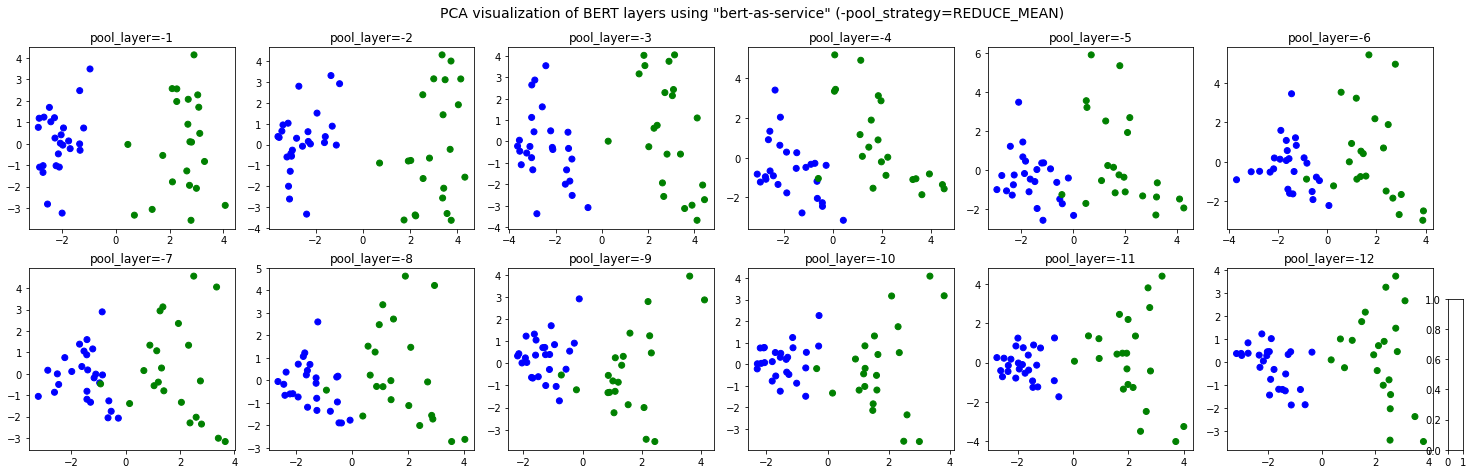

In [93]:
visualise_pca(pca_embed)

In [89]:
print(len(sentences))
print(len(music_sentences))
print(len(computer_sentences))

48
26
22


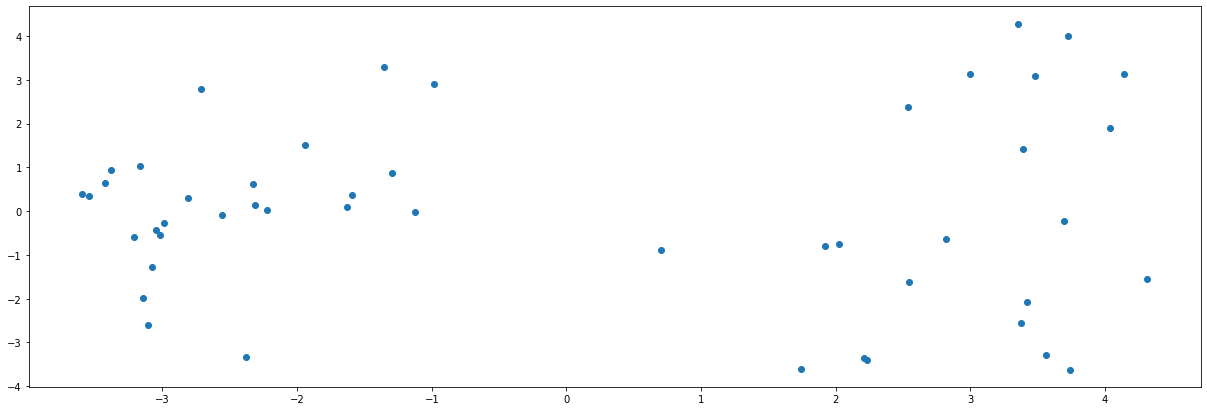

In [95]:
_2_embed = pca_embed[1]
plt.scatter(_2_embed[:, 0], _2_embed[:, 1]c=labels, cmap=ListedColormap(["blue", "green"]))